# Quantum Image Processing
A series of python modules for implementing Quantum Image and Signal Processing protocols for image encoding, which fulfills the challenge "Preparing for Battle".

The report goes through several embedding schemes we have come up with that are either good for simulating (simulator friendly encodings) and NISQ friendly hardware friendly. 
The main feature is that we have implemented an embedding in qiskit for the FRQI-QPIXL framework  (Amankwah et al., May 2022, https://www.nature.com/articles/s41598-022-11024-y ). 
This is included in two folders, one for a qiskit version and another for a pennylane version.  ```qpixl.py``` for the full version with compression, and  ```param_qpixl.py``` contains the parameterized version that can be used to generate a NISQ friendly image feature map for QML amongst other things.

- Contents
    - Introduction
    - QPIXL (```QPIXL.ipynb```)
    - compression
    - Implement multiple images in the same circuit

# QPIXL


## Introduction

### Quantum killers for NISQ
The depth (and connectivity) of a circuit completely determines how well it can be implemented on existing hardware. The killing blow to most
algorithms is that they require fully connected and very deep circuits (which get decomposed to even deeper circuits with limited gatesets). 
Due to non-zero error rates, the probability that at least an error has occured throughout the run of a circuit eventually becomes 1. This can
be mitigated, but at some point it can't be done. This is why short circuits for flexible data embeddings are so important.

### Images in quantum computing
Although quantum computers have a more obvious to see advantage in quantum tasks, nonetheless it is thought that we can see some advantages in tasks involving
classical data loaded onto a quantum computer. Although pictures may not be 'the' data-type that will see an advantage from quantum computing, it is nonetheless 
the case that a lot of data can be input in an image-like format, and studying pictoral algorihtms is definitely way easier on the eyes than pure data-driven tasks! 
Also, with a quantum state representing an image, you can see the results of any quantum transformation of the picture as a new picture! Of course, it needs to be 
seen from many 'angles', but maybe it can help with visualizing what 

## QPIXL algorithm

Why do we need another type of embedding in the mix? QPIXL is a framework to decompose popular image encodings such as FRQI, NEQR and their improved counterparts. 
It works by optimally decomposing the gates, and removing any 0 angles that are found. Thanks to the optimal decomposition
the quantum gates can then be further reduced by removing pairs of CNOTS that used to be interweaved by rotation gates. 
They cancel out an become the identity. 
The FRQI embedding looks as follows: 

In [1]:
from QPIXL_qiskit.helper import *
from QPIXL_qiskit.qpixl_parallel import *
from qiskit.visualization import *
from qiskit_aer import StatevectorSimulator
import qiskit 
backend = StatevectorSimulator(method="statevector")

In [2]:
from PIL import Image
import matplotlib.pyplot as plt


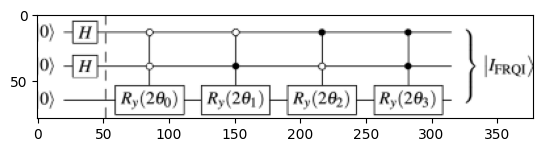

In [4]:
frqi_img = Image.open('figures/frqi.png')
plt.imshow(frqi_img)
plt.show()

but decomposed into CNOTS and rotations it looks like this!

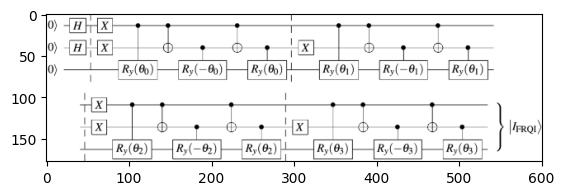

In [5]:
frqi_decomp_img = Image.open('figures/frqi_decomp.png')
plt.imshow(frqi_decomp_img)
plt.show()

With QPIXL, the basic embedding, after transforming the image into an angle representation (using arctangent on the pixel values and a walsh hadamard transform) you have this much shorter decomposition! 
And this implies that we encode each of its elements into the amplitudes of the wave function.

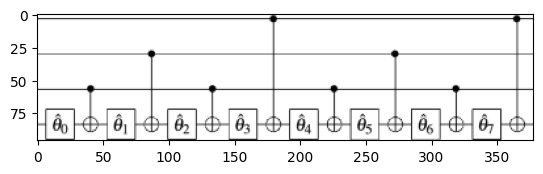

In [6]:
plt.close()
qpixl_decomp_img = Image.open('figures/qpixl_decomp.png')
plt.imshow(qpixl_decomp_img)
plt.show()

## Implement multiple images in the same circuit

Moreover, a extension of QPIXL, QCrank, is developed and published this year, which encodes a series of real-valued data as rotations on data qubits
(Balewski, J., Amankwah, M.G., Van Beeumen, R. et al., Sci Rep 14, 3435 (2024), https://doi.org/10.1038/s41598-024-53720-x). 
That is to say, multiple data encoding in one qubit is possble.
The QCrank method looks as follow:

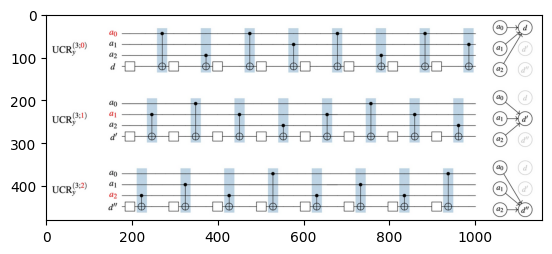

In [8]:
plt.close()
qcrank_img1 = Image.open('figures/QCrank_1.png')
plt.imshow(qcrank_img1)
plt.show()

In the figure, a cyclic permuted UCRs for 3 address and 1 data qubits is shown.
As a result, 3 different permutations acting on 3 data qubits can be reordered to an equivalent circuit with the same critical depth as a single circuit operating on 1 data qubit.

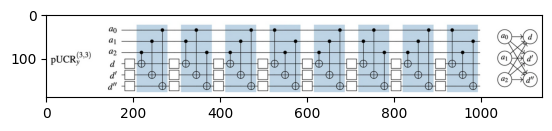

In [9]:
plt.close()
qcrank_img2 = Image.open('figures/QCrank_2.png')
plt.imshow(qcrank_img2)
plt.show()

In below, we show a example including two images encoding to the circuit through Qcrank.

In [10]:
img = Image.open('figures/creation_world.png')
img2 = Image.open('figures/cat.webp')

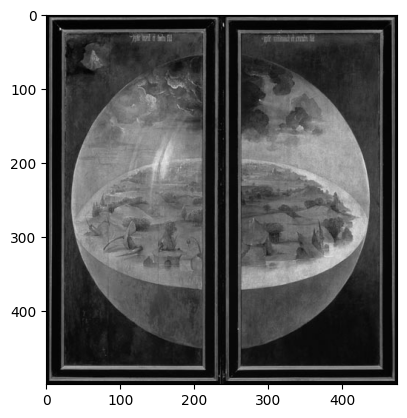

In [11]:
plt.imshow(img)
plt.show()

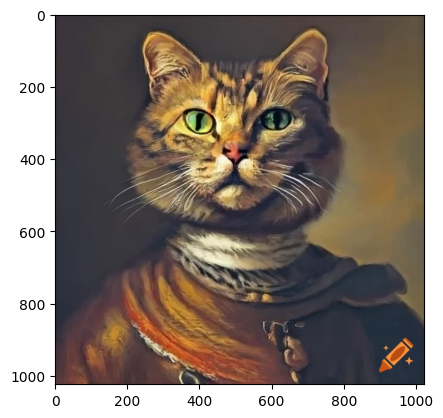

In [12]:
plt.imshow(img2)
plt.show()

The size of images is rescale to 64*64.

In [13]:
img = img.convert('L')
img = np.array(img.resize((64,64), Image.Resampling.LANCZOS))
img2 = img2.convert('L')
img2 = np.array(img2.resize((64,64), Image.Resampling.LANCZOS))
print(img2.shape,img.shape)

(64, 64) (64, 64)


In the circuit, we need 12+2 qubits including 12 qubits to store postions of 64*64 pixels. And color information require 1 qubit for each image. In this example, we have two images.

In [27]:
shape = img.shape
np_frame = [np.array(img).T.flatten(),np.array(img2).T.flatten()] #sometimes you have to transpose the image for the decoding to make sense
decoded_data = []
labels = []
comp_str = "Compression: "+str(0)+"% \n"
qc = cFRQI(np_frame,0)
job = backend.run(qc)
depth_str = " Circuit depth: "+str(qc.depth())
#### Just for show
sv = np.real(job.result().get_statevector())
decoded = decodeParallelQPIXL(sv,qc,len(np_frame))
for datum in decoded:
    decoded_data.append(reconstruct_img(datum, shape))
labels.append(comp_str+depth_str)


12
[0]
[1]


In [28]:
len(np_frame) # number of images stored in the circuit

2

In [29]:
np.log2(len(np_frame[0])) # data points per image

12.0

In [30]:
len(qc.qubits) # total qubits in circuit

14

The depth of the circuit is shown below.

In [23]:
labels

['Compression: 0% \n Circuit depth: 8192']

In order to show, the data is encoded into the circuit.
We also show recoverd images by decoding circuit

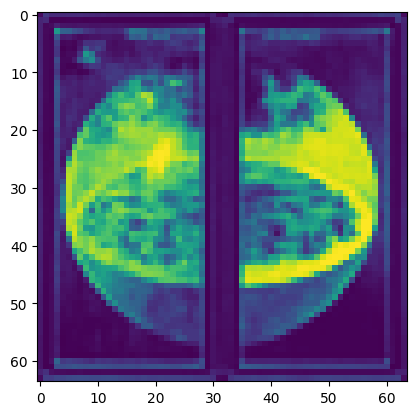

In [31]:
plt.imshow(decoded_data[0])

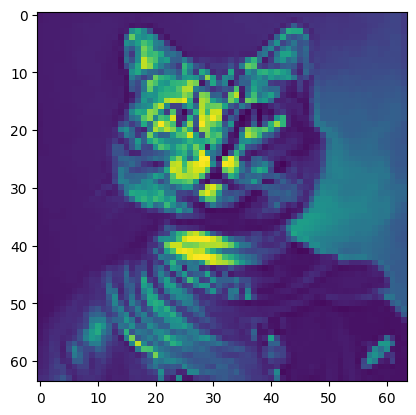

In [32]:
plt.imshow(decoded_data[1])

In [19]:
def permute_bits(b,bitlength=8,shift=1):
    b = bin(b)
    b = b[2:].zfill(bitlength)
    b = [b[(i + shift) % len(b)] for i in range(len(b))]
    return int(''.join(b),2)

In [20]:
dataset = 0
traced_over_qubits = [ qc.qubits.index(qubit) for qubit in [qc.qubits[other] for other in [0,1,2]] ]
print(traced_over_qubits)
density_matrix = qiskit.quantum_info.partial_trace(sv, traced_over_qubits)
probs = density_matrix.probabilities()
test = decodeQPIXL(probs)
ordered = [test[permute_bits(i,len(qc.qubits)-len(np_frame),dataset)] for i in range(len(test))]
plt.imshow(reconstruct_img(ordered, shape))

[0, 1, 2]


IndexError: list index out of range

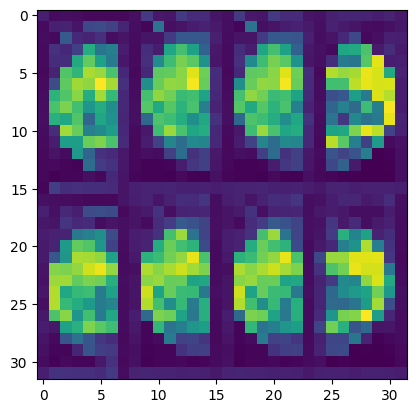

In [7]:
plt.imshow(decoded_data[1])